In [2]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [3]:
train = pd.read_csv("/workspaces/ML-project-2025/data/train.csv")
test  = pd.read_csv("/workspaces/ML-project-2025/data/test.csv")

train['dataset'] = 'train'
test['dataset'] = 'test'

df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848563 entries, 0 to 848562
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    848563 non-null  int64  
 1   annual_income         848563 non-null  float64
 2   debt_to_income_ratio  848563 non-null  float64
 3   credit_score          848563 non-null  int64  
 4   loan_amount           848563 non-null  float64
 5   interest_rate         848563 non-null  float64
 6   gender                848563 non-null  object 
 7   marital_status        848563 non-null  object 
 8   education_level       848563 non-null  object 
 9   employment_status     848563 non-null  object 
 10  loan_purpose          848563 non-null  object 
 11  grade_subgrade        848563 non-null  object 
 12  loan_paid_back        593994 non-null  float64
 13  dataset               848563 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 90.

In [5]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

In [6]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0]
print(missing_df.sort_values(by='Percentage', ascending=False))

                Missing Values  Percentage
loan_paid_back          254569   30.000012


# EDA

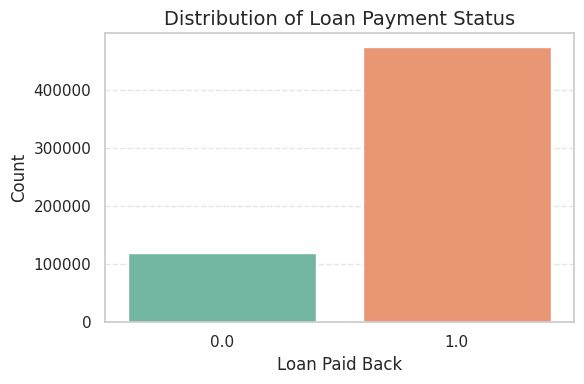

In [7]:
plt.figure(figsize=(6, 4))
# Use 'countplot' for categorical data
sns.countplot(data=df, x='loan_paid_back', palette='Set2')

plt.title('Distribution of Loan Payment Status', fontsize=14)
plt.xlabel('Loan Paid Back', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# Extract numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('id')  # Remove ID column if present

# Extract continuous columns (numerical columns with more than a threshold of unique values)
continuous_cols = [col for col in numerical_cols if df[col].nunique() > 10]

# Extract categorical columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Print the results
print("Numerical Columns:", numerical_cols)
print("Continuous Columns:", continuous_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back']
Continuous Columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical Columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'dataset']


--- Visualizing: annual_income ---


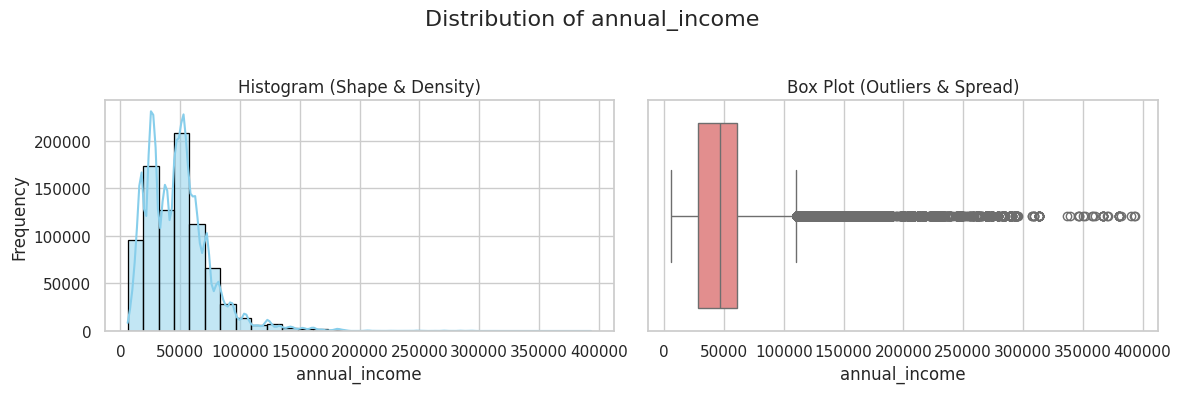


📊 Descriptive Statistics:
count    848563.000
mean      48218.466
std       26714.243
min        6002.430
25%       27939.785
50%       46552.600
75%       61003.900
max      393381.740
Name: annual_income, dtype: float64


--- Visualizing: debt_to_income_ratio ---


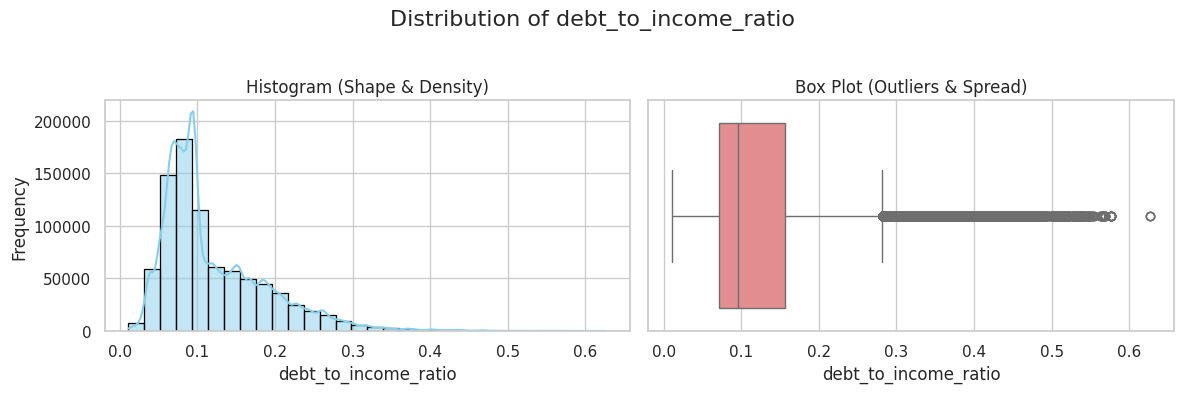


📊 Descriptive Statistics:
count    848563.000
mean          0.121
std           0.069
min           0.011
25%           0.072
50%           0.096
75%           0.156
max           0.627
Name: debt_to_income_ratio, dtype: float64


--- Visualizing: credit_score ---


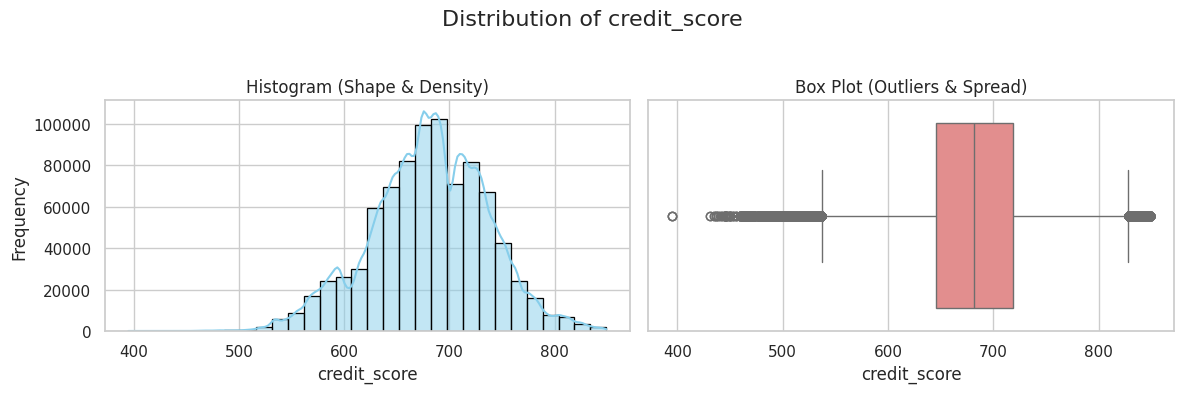


📊 Descriptive Statistics:
count    848563.000
mean        680.953
std          55.485
min         395.000
25%         646.000
50%         682.000
75%         719.000
max         849.000
Name: credit_score, dtype: float64


--- Visualizing: loan_amount ---


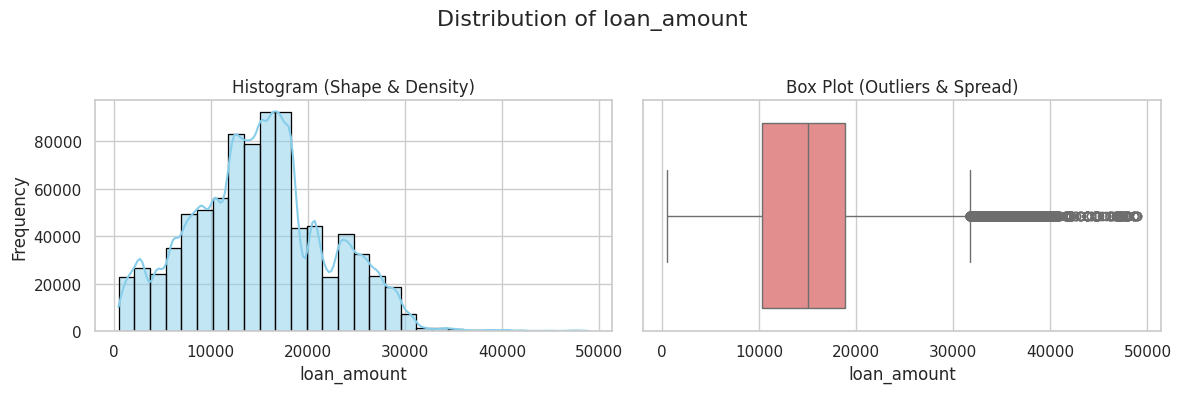


📊 Descriptive Statistics:
count    848563.000
mean      15019.234
std        6925.217
min         500.050
25%       10275.010
50%       15000.220
75%       18851.520
max       48959.950
Name: loan_amount, dtype: float64


--- Visualizing: interest_rate ---


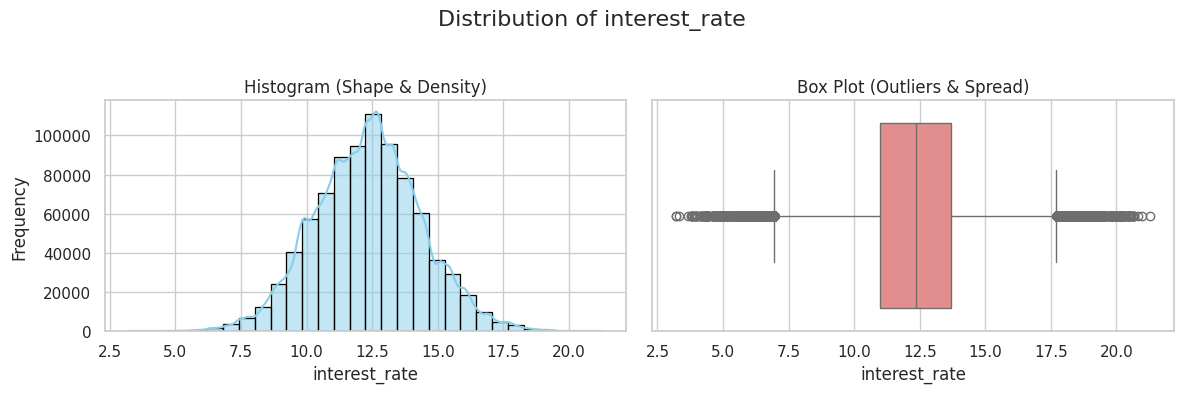


📊 Descriptive Statistics:
count    848563.000
mean         12.355
std           2.012
min           3.200
25%          10.990
50%          12.370
75%          13.680
max          21.290
Name: interest_rate, dtype: float64


--- Visualizing: loan_paid_back ---


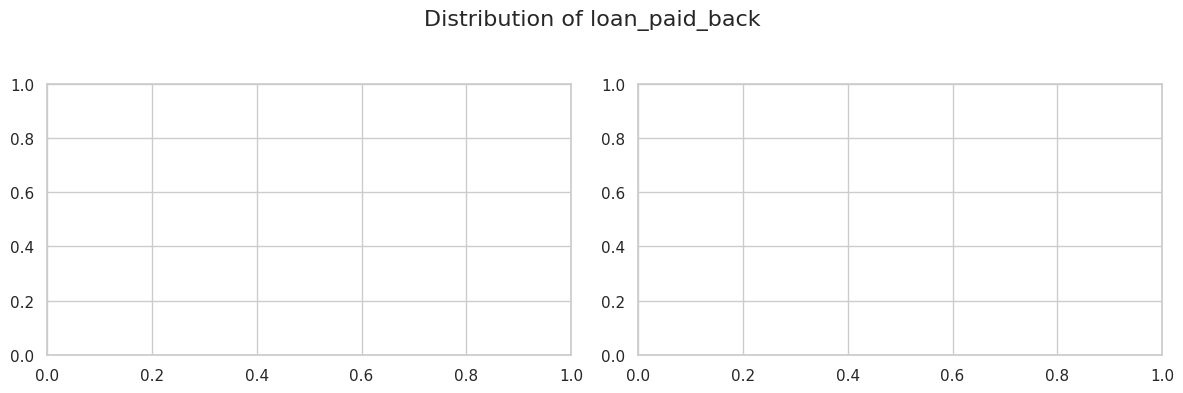


📊 Descriptive Statistics:
count    593994.000
mean          0.799
std           0.401
min           0.000
25%           1.000
50%           1.000
75%           1.000
max           1.000
Name: loan_paid_back, dtype: float64




In [9]:
discrete_features = []

# Loop through each numerical column
for col in numerical_cols:
    print(f"--- Visualizing: {col} ---")

    # Set up a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Distribution of {col}', fontsize=16)

    if col in continuous_cols:
        # Left: Histogram for density/shape
        sns.histplot(df[col].dropna(), kde=True, bins=30,
                     ax=axes[0], color='skyblue', edgecolor='black')
        axes[0].set_title('Histogram (Shape & Density)')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Right: Boxplot for quartiles/outliers
        sns.boxplot(x=df[col].dropna(), ax=axes[1], color='lightcoral')
        axes[1].set_title('Box Plot (Outliers & Spread)')
        axes[1].set_xlabel(col)

    elif col in discrete_features:
        # Left: Count Plot for small integer-like features
        sns.countplot(x=df[col].dropna(), ax=axes[0], palette='viridis', edgecolor='black')
        axes[0].set_title('Count Plot (Frequency)')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')

        # Right: Boxplot (still useful)
        sns.boxplot(x=df[col].dropna(), ax=axes[1], color='lightcoral')
        axes[1].set_title('Box Plot (Summary)')
        axes[1].set_xlabel(col)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print descriptive statistics
    print("\n📊 Descriptive Statistics:")
    print(df[col].describe().round(3))
    print("\n" + "="*50 + "\n")

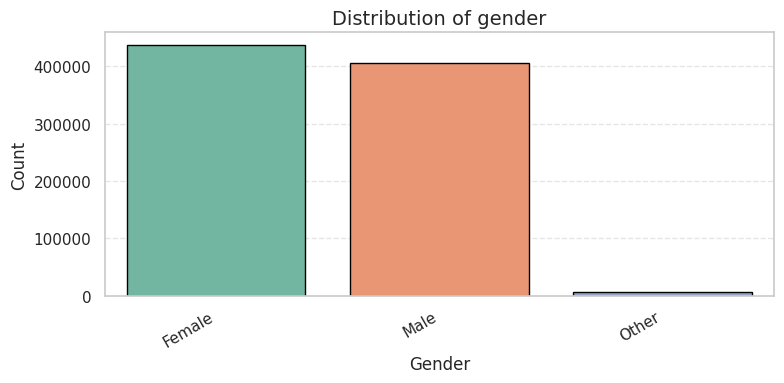


📊 Proportion of Each Category in "gender":

gender
Female    0.516
Male      0.478
Other     0.006
Name: proportion, dtype: float64 
----------------------------------------


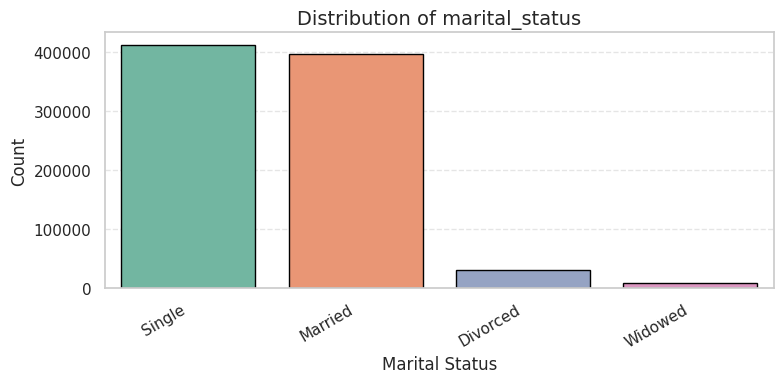


📊 Proportion of Each Category in "marital_status":

marital_status
Single      0.486
Married     0.467
Divorced    0.036
Widowed     0.011
Name: proportion, dtype: float64 
----------------------------------------


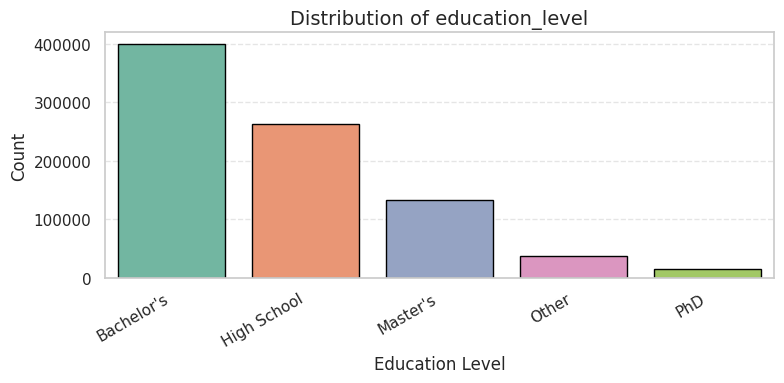


📊 Proportion of Each Category in "education_level":

education_level
Bachelor's     0.471
High School    0.309
Master's       0.157
Other          0.045
PhD            0.019
Name: proportion, dtype: float64 
----------------------------------------


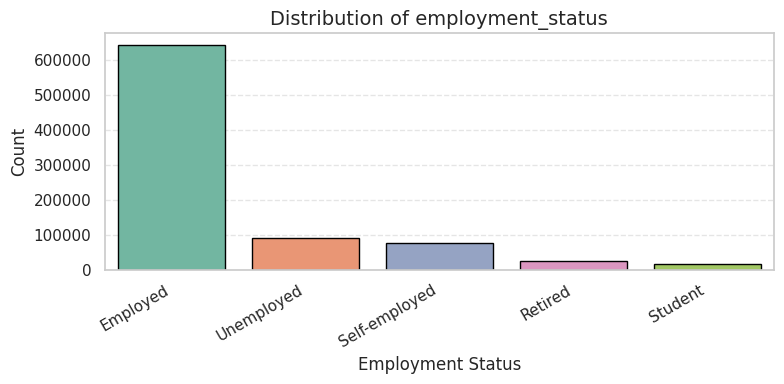


📊 Proportion of Each Category in "employment_status":

employment_status
Employed         0.759
Unemployed       0.105
Self-employed    0.088
Retired          0.028
Student          0.020
Name: proportion, dtype: float64 
----------------------------------------


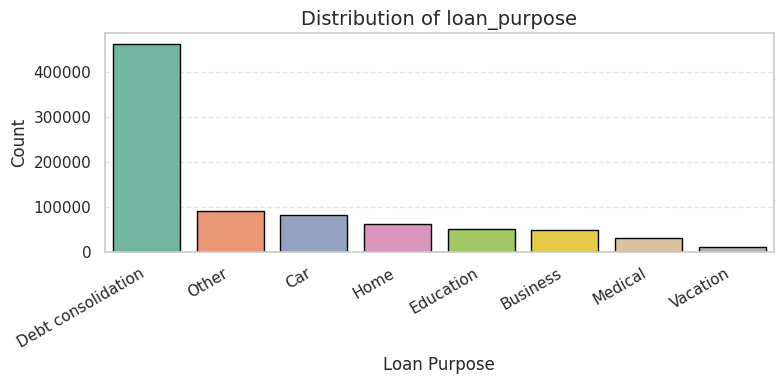


📊 Proportion of Each Category in "loan_purpose":

loan_purpose
Debt consolidation    0.546
Other                 0.108
Car                   0.098
Home                  0.074
Education             0.062
Business              0.059
Medical               0.038
Vacation              0.014
Name: proportion, dtype: float64 
----------------------------------------


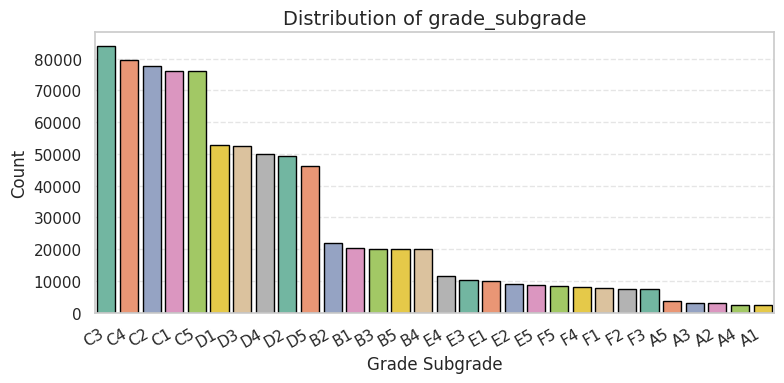


📊 Proportion of Each Category in "grade_subgrade":

grade_subgrade
C3    0.099
C4    0.094
C2    0.092
C1    0.090
C5    0.090
D1    0.062
D3    0.062
D4    0.059
D2    0.058
D5    0.054
B2    0.026
B1    0.024
B3    0.024
B5    0.024
B4    0.023
E4    0.013
E3    0.012
E1    0.012
E2    0.011
E5    0.010
F5    0.010
F4    0.009
F1    0.009
F2    0.009
F3    0.009
A5    0.004
A3    0.004
A2    0.003
A4    0.003
A1    0.003
Name: proportion, dtype: float64 
----------------------------------------


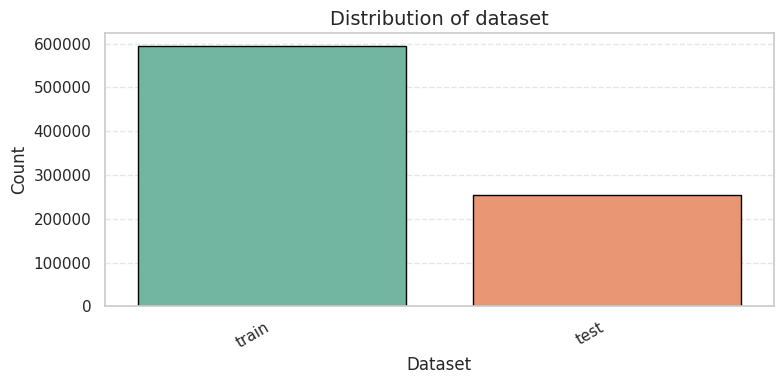


📊 Proportion of Each Category in "dataset":

dataset
train    0.7
test     0.3
Name: proportion, dtype: float64 
----------------------------------------


In [10]:
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        data=df,
        x=col,
        order=df[col].value_counts().index,  # order bars by frequency
        palette='Set2',
        edgecolor='black'
    )

    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Rotate labels if categories are long
    plt.xticks(rotation=30, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 🧮 Print Category Proportions
    print(f'\n📊 Proportion of Each Category in "{col}":\n')
    print(df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

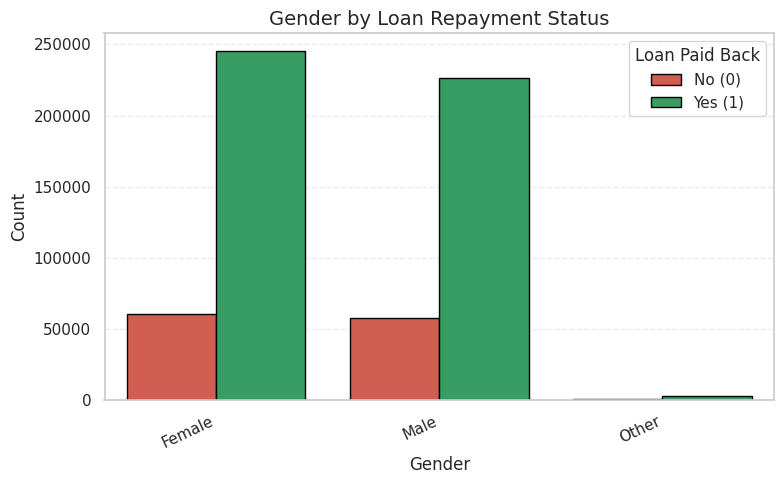

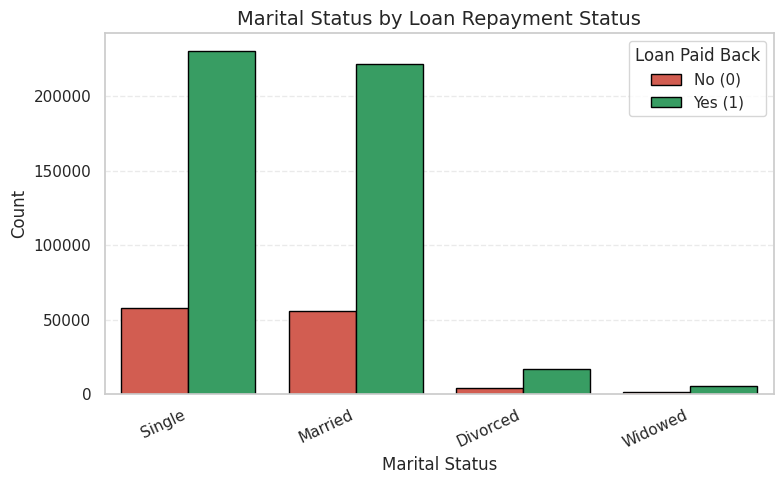

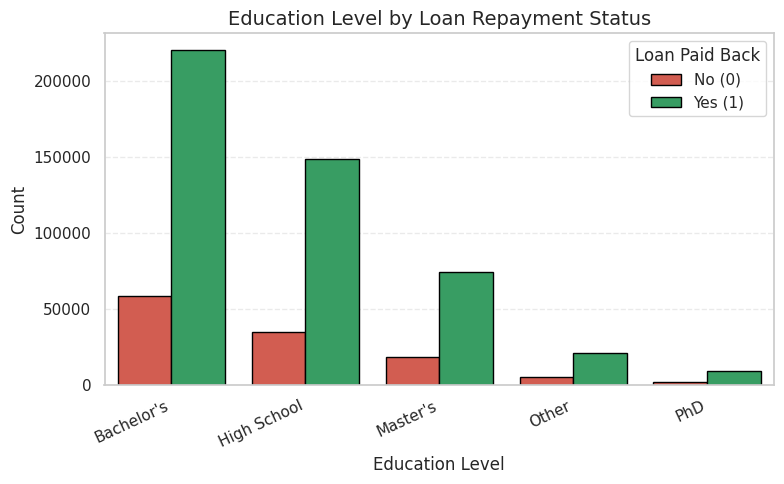

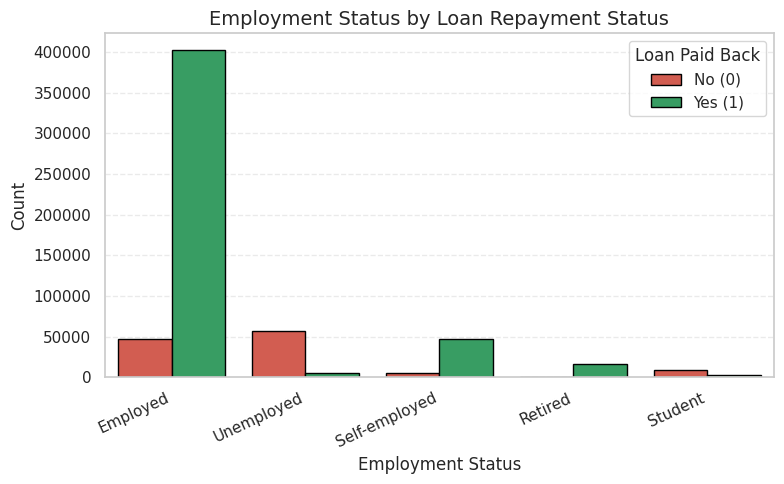

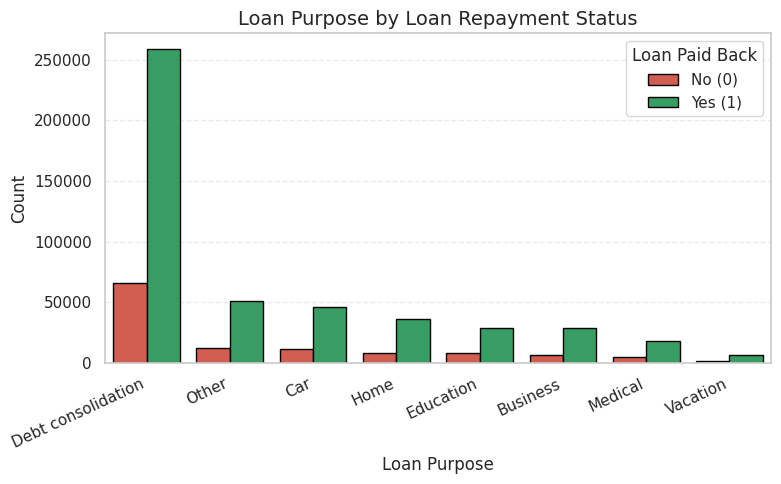

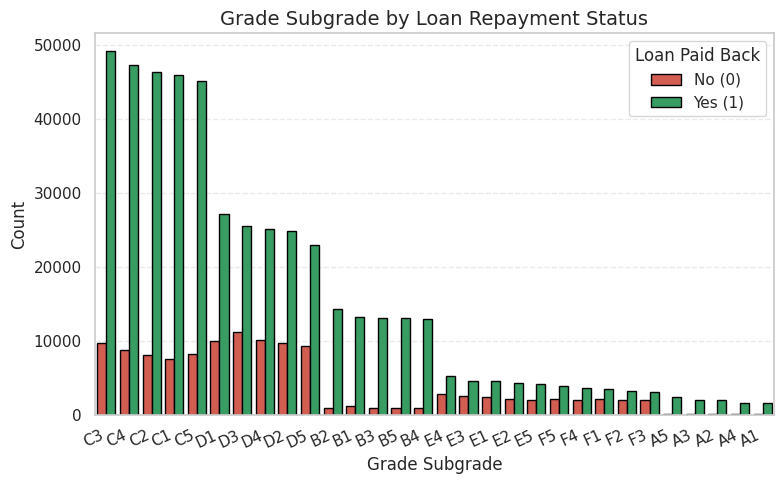

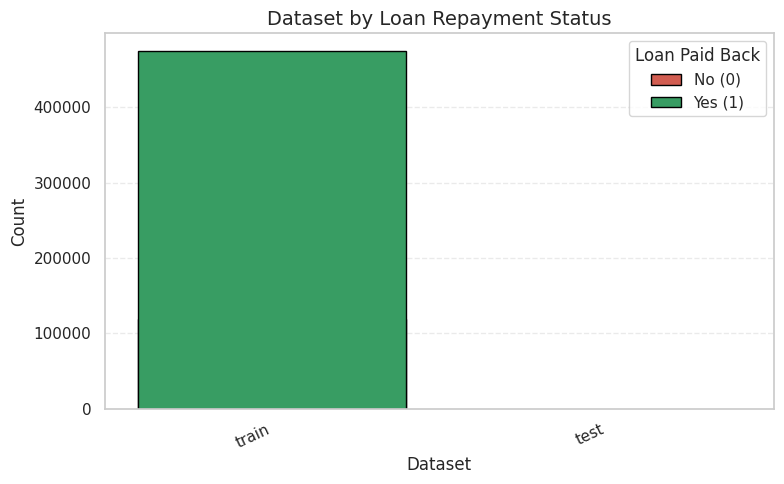

In [11]:
custom_palette = ['#E74C3C', '#27AE60']  # Red = Not Paid, Green = Paid

target_col = 'loan_paid_back'  # Binary target variable (0 or 1)

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=df,
        x=col,
        hue=target_col,
        palette=custom_palette,
        edgecolor='black',
        order=df[col].value_counts().index  # Order bars by frequency
    )
    
    plt.title(f'{col.replace("_", " ").title()} by Loan Repayment Status', fontsize=14)
    plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=25, ha='right')
    
    # Legend reflecting your target variable meaning
    plt.legend(title='Loan Paid Back', labels=['No (0)', 'Yes (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

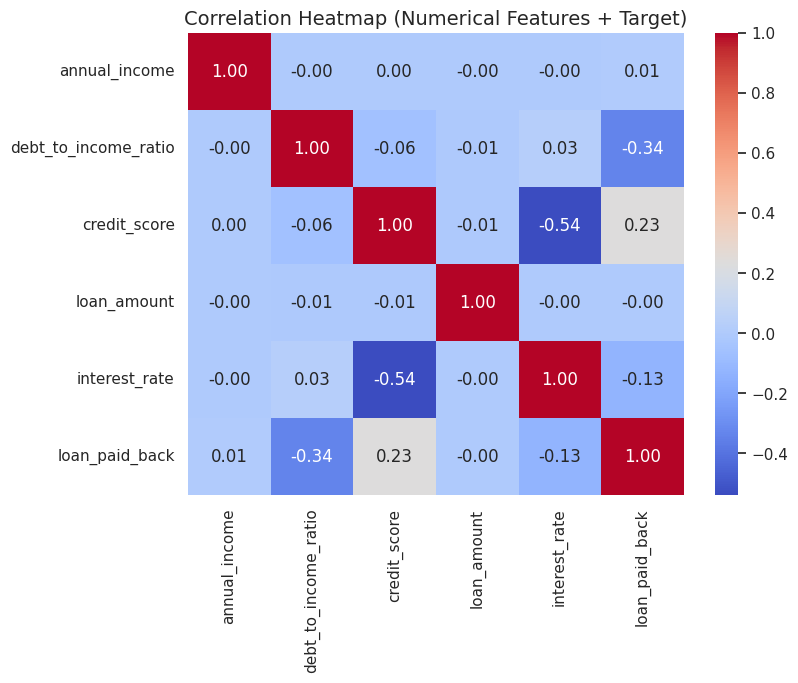

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['annual_income', 'debt_to_income_ratio', 'credit_score', 
                'loan_amount', 'interest_rate', 'loan_paid_back']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numerical Features + Target)', fontsize=14)
plt.show()

In [13]:
def create_advanced_features(df):
    df = df.copy()

    # Core affordability
    df['income_loan_ratio'] = df['annual_income'] / df['loan_amount'].replace(0, np.nan)
    df['loan_to_income'] = df['loan_amount'] / df['annual_income'].replace(0, np.nan)
    
    # Debt metrics
    df['total_debt'] = df['debt_to_income_ratio'] * df['annual_income']
    df['available_income'] = df['annual_income'] * (1 - df['debt_to_income_ratio'])
    df['debt_burden'] = df['debt_to_income_ratio'] * df['loan_amount']
    
    # Payment analysis (simple proxy)
    df['monthly_payment'] = df['loan_amount'] * df['interest_rate'] / 1200
    df['payment_to_income'] = df['monthly_payment'] / (df['annual_income'] / 12).replace(0, np.nan)
    df['affordability'] = df['available_income'] / df['loan_amount'].replace(0, np.nan)
    
    # Risk scoring
    df['default_risk'] = (
        df['debt_to_income_ratio'] * 0.40 + 
        (850 - df['credit_score']) / 850 * 0.35 + 
        df['interest_rate'] / 100 * 0.25
    ).clip(0, 1)
    
    # Credit analysis
    df['credit_utilization'] = df['credit_score'] * (1 - df['debt_to_income_ratio'])
    df['credit_interest_product'] = df['credit_score'] * df['interest_rate'] / 100
    
    # Log transformations
    for col in ['annual_income', 'loan_amount']:
        df[f'{col}_log'] = np.log1p(df[col].clip(lower=0))
    
    # Grade parsing
    df['grade_letter'] = df['grade_subgrade'].astype(str).str[0]
    df['grade_number'] = (
        df['grade_subgrade'].astype(str).str[1:].str.extract(r'(\d+)')[0].astype('float')
    )
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['grade_rank'] = df['grade_letter'].map(grade_map).astype('float')
    
    return df

In [14]:
NEW_FEATURES = [
    'income_loan_ratio', 'loan_to_income', 'total_debt', 
    'available_income', 'debt_burden', 'monthly_payment',
    'payment_to_income', 'affordability', 'default_risk',
    'credit_utilization', 'credit_interest_product',
    'annual_income_log', 'loan_amount_log', 'grade_letter',
    'grade_number', 'grade_rank'
]

print(f"Created {len(NEW_FEATURES)} new features")

df = create_advanced_features(df)

Created 16 new features


In [15]:
# Split into train/test sets
train_df = df[df["dataset"] == "train"].copy()
test_df = df[df["dataset"] == "test"].copy()

X_train = train_df.drop(["id", "loan_paid_back", "dataset"], axis=1)
y_train = train_df["loan_paid_back"]

X_test = test_df.drop(["id", "loan_paid_back", "dataset"], axis=1)

In [16]:
num_cols = [
    "annual_income",
    "debt_to_income_ratio",
    "credit_score",
    "loan_amount",
    "interest_rate"
]

cat_cols = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade"
]

# You can add binary flags (if any exist)
bool_cols = []  

# Columns to encode using Target Encoding (categorical + bools)
cols_to_encode = cat_cols + bool_cols

# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("target_enc", TargetEncoder(cols=cols_to_encode, smoothing=25.0), cols_to_encode),
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="drop"
)

In [32]:
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)

In [30]:
s = pd.read_csv("X_train.csv")

Accuracy:  0.9052
Precision: 0.9095
Recall:    0.9786
F1-score:  0.9428
ROC-AUC:   0.9217

MODEL PERFORMANCE SUMMARY (5-Fold CV)
         Accuracy  Precision  Recall      F1  ROC_AUC
XGBoost    0.9052     0.9095  0.9786  0.9428   0.9217


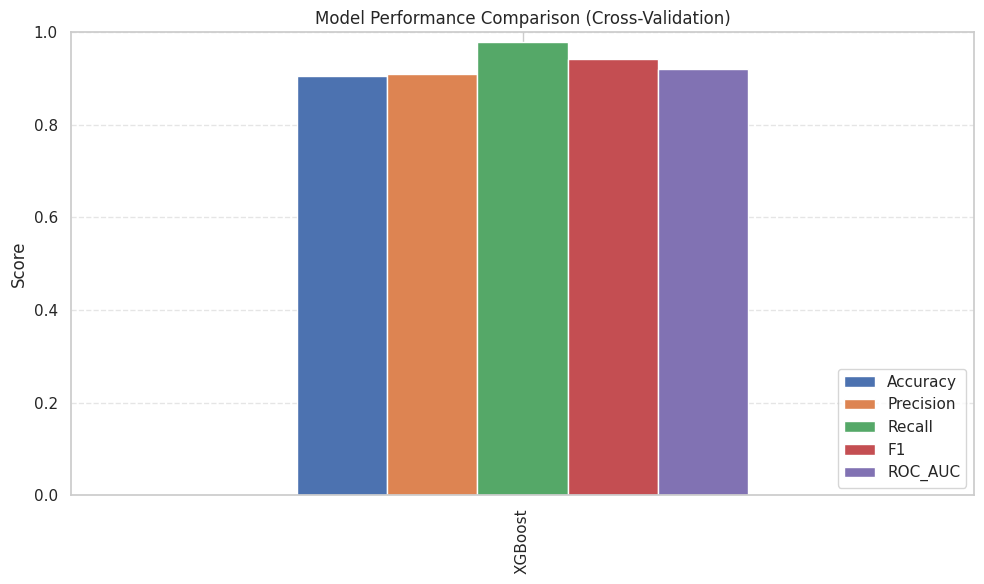

In [28]:
X = X_train
y = y_train

cv_results = {}

# Classification metrics
scoring = {
    "Accuracy": "accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "F1": "f1",
    "ROC_AUC": "roc_auc"
}

# XGBoost Hyperparameters (Tuned for 80/20 Imbalance)
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist' # Faster training
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
scores = []

model = XGBClassifier(**params)
models = {"XGBoost":model}
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=kf,
        scoring=scoring,
        n_jobs=-1
    )

    cv_results[name] = {metric: np.mean(scores) for metric, scores in cv_scores.items() if "test_" in metric}

    print(f"Accuracy:  {cv_results[name]['test_Accuracy']:.4f}")
    print(f"Precision: {cv_results[name]['test_Precision']:.4f}")
    print(f"Recall:    {cv_results[name]['test_Recall']:.4f}")
    print(f"F1-score:  {cv_results[name]['test_F1']:.4f}")
    print(f"ROC-AUC:   {cv_results[name]['test_ROC_AUC']:.4f}")

results_df = pd.DataFrame({
    model: {
        "Accuracy": cv_results[model]["test_Accuracy"],
        "Precision": cv_results[model]["test_Precision"],
        "Recall": cv_results[model]["test_Recall"],
        "F1": cv_results[model]["test_F1"],
        "ROC_AUC": cv_results[model]["test_ROC_AUC"]
    } for model in cv_results.keys()
}).T.round(4)

print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY (5-Fold CV)")
print("=" * 80)
print(results_df)

# Optional: plot comparison
results_df.plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison (Cross-Validation)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
xgboost.__version__